# This is a note to show the ratation diffusion and reverse process

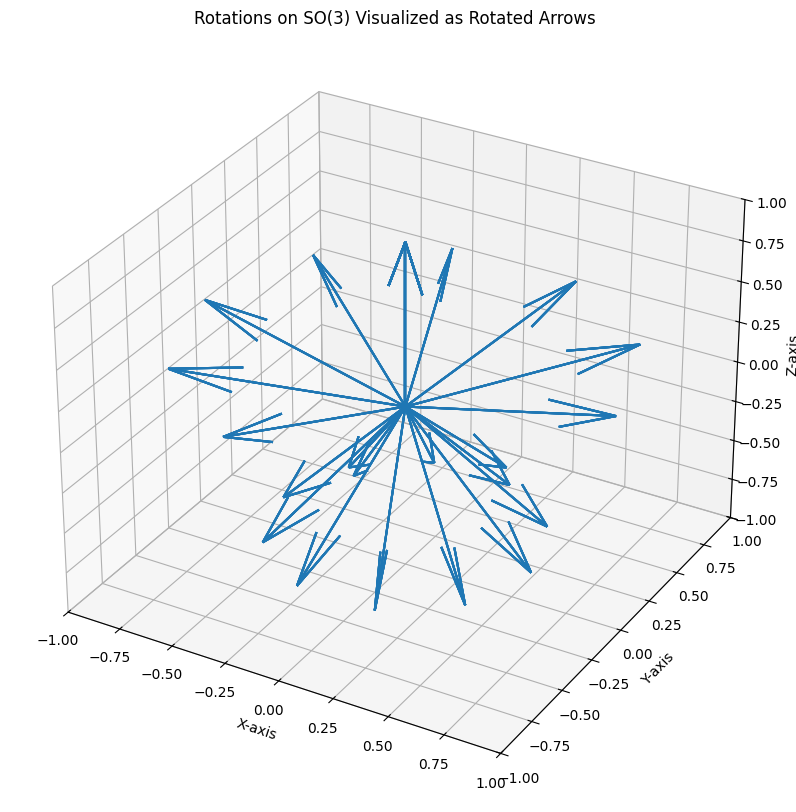

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def generate_so3_grid(n):
    """
    Generate a grid on SO(3) using discretized Euler angles.
    
    Args:
        n (int): Number of samples along each Euler angle dimension.
    
    Returns:
        rotations (list of np.ndarray): List of rotation matrices.
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    grids = [(a1, a2, a3) for a1 in angles for a2 in angles for a3 in angles]
    rotations = [R.from_euler('zyz', g).as_matrix() for g in grids]
    return rotations

def plot_rotations(rotations, arrow_length=1.0):
    """
    Visualize rotations on SO(3) by applying them to a 3D arrow.
    
    Args:
        rotations (list of np.ndarray): List of rotation matrices.
        arrow_length (float): Length of the arrows to plot.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define the arrow: starts at origin, points along z-axis
    arrow = np.array([[0, 0, 0], [0, 0, arrow_length]])
    
    # Plot each rotation
    for R in rotations:
        rotated_arrow = arrow @ R.T
        ax.quiver(
            rotated_arrow[0, 0], rotated_arrow[0, 1], rotated_arrow[0, 2],
            rotated_arrow[1, 0] - rotated_arrow[0, 0],
            rotated_arrow[1, 1] - rotated_arrow[0, 1],
            rotated_arrow[1, 2] - rotated_arrow[0, 2],
            length=arrow_length,
            normalize=True,
        )
    
    # Set the axes limits and labels
    ax.set_xlim([-arrow_length, arrow_length])
    ax.set_ylim([-arrow_length, arrow_length])
    ax.set_zlim([-arrow_length, arrow_length])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('Rotations on SO(3) Visualized as Rotated Arrows')
    plt.show()

# Example usage
rotations = generate_so3_grid()  # Adjust grid density
plot_rotations(rotations)


In [3]:
# sample one rotation
def sample_rotation():
    """
    Sample a random rotation matrix from SO(3).
    
    Returns:
        rotation (np.ndarray): A random rotation matrix.
    """
    r = R.random()
    return r.as_matrix()

# Example usage of sampling a random rotation
r_truth = sample_rotation() # use it as the ground truth



In [4]:
import sys
sys.path.append('/home/yunyao/RFdiffusion/rfdiffusion')

from util import rigid_from_3_points

In [5]:
# generate the diffusion process
from diffusion import IGSO3

T=200
min_sigma=0
max_sigma=1
min_b=0
max_b=1
cache_dir='./cache'

# rotation noise linear schedulear sigma(t) = sigma_min + (t/T)*beta_min + 1/2(t/T)^2(beta_max-beta_min)
# sigma_min = 0.02, beta_min =1.06  beta_max=1.77
# rotation noise log schedular  log(sigma(t))= logsigma_min + t/T * (log(sigma_max)-log(sigma_min))

# in the SI, it seems the linear one is used and max_sigma is not used
test = IGSO3(T=T,
        min_sigma=0.02,
        max_sigma=1,
        min_b=1.06,
        max_b=1.77,
        cache_dir=cache_dir,
        num_omega=1000,
        schedule="linear",
        L=2000)

In [6]:
from abc import ABC, abstractmethod
from typing import Optional
import math
import torch
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
            - dt: time, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (nts,)
        Returns:
            - x_final: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [ ]:
from scipy.spatial.transform import Rotation as scipy_R
class EulerMaruyama(Simulator):
    def __init__(self, diffuser):
        """
        Args:
            - beta_schedule: beta schedule, shape (num_timesteps,)
            - sigma_schedule: sigma schedule, shape (num_timesteps,)
            - noise_type: type of noise to add, either "linear" or "log"
        """
        super().__init__()
        self.diffuser = diffuser

    def step(self, rt: torch.Tensor, r0:torch.tensor, ts: torch.Tensor, ):
        """
        Takes one simulation step
        Args:
            - rt: state at time t, shape ( num_residues, 3, 3)
            - ts: time , shape () [1,...,T]
            - x0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - nxt: reverse to xt-1
        """
        # Get the beta and sigma values for the current timestep

        # Sample rotations and scores from IGSO3

        num_res=rt.shape[0]
        t = np.arange(self.diffuser.T) + 1
        sampled_rots = self.diffuser.sample_vec(t, n_samples=num_res)  # [T, N, 3]
        # Apply sampled rot.
        R_sampled = (
            scipy_R.from_rotvec(sampled_rots.reshape(-1, 3))
            .as_matrix()
            .reshape(self.diffuser.T, num_res, 3, 3)
        )
        R_perturbed = np.einsum("tnij,njk->tnik", R_sampled, R_0)

        return R_perturbed
    
    def simulate_with_trajectory(self, x: torch.Tensor, x0: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
            - x0: the truth structure, shape (batch_size, num_residues, 3, 3)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            x = self.step(x, x0, t)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [9]:
# the forward process
import torch
diffused_frame = test.diffuse_frames(torch.tensor(r_truth).clone(), diffusion_mask=None, t_list=None)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed